<a href="https://colab.research.google.com/github/raduga256/Text-Classification-with-NLP-Tf-Idf-vs-Word2Vec-vs-BERT/blob/main/news_category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## New Category Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT

There are different techniques to extract information from raw text data and use it to train a classification model. This tutorial compares the old school approach of Bag-of-Words (used with a simple machine learning algorithm), the popular Word Embedding model (used with a deep learning neural network), and the state of the art Language models (used with transfer learning from attention-based transformers) that have completely revolutionized the NLP landscape.

This article yourself first appearance paper of LIME in certain seminars "Why Should I Trust You?": Explaining the Predictions of Any Classifierare based on a slide that was announced.
https://irisu-inwl.github.io/reveal/lime

However, because this slide there is a feeling that was made for those who do not know the machine learning, it was summarized as anew article.

In [1]:
!pip -qq install lime

     |████████████████████████████████| 276kB 7.4MB/s 


In [2]:
 # Installing the Tranformers Library
 !pip -qq install transformers

     |████████████████████████████████| 2.1MB 7.3MB/s 
     |████████████████████████████████| 3.3MB 38.7MB/s 
     |████████████████████████████████| 870kB 55.1MB/s 


In [33]:
# First of all, I need to import the following libraries:

## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers


The dataset is contained into a json file, so I will first read it into a list of dictionaries with json and then transform it into a pandas Dataframe.

In [4]:
lst_dics = []
gdrive_loc = '/content/drive/My Drive/Colab Notebooks/'
with open(gdrive_loc+ "News_Category_Dataset_v2.json", mode='r', errors='ignore') as json_file :
  for dic in json_file:
    lst_dics.append(json.loads(dic))

## print the first one
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

The original dataset contains over 30 categories, but for the purposes of this project, I will work with a subset of 3: Entertainment, Politics, and Tech.

In [5]:
## create datafrmae dtf
dtf = pd.DataFrame(lst_dics)

## filter categories
#dtf = dtf['category'].isin(['ENTERTAINMENT','POLITICS','TECH'])[["category","headline"]]

## rename columns
#dtf = dtf.rename(columns={"category":"y", "headline":"text"})

## print random rows
dtf.head(5)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]

## rename columns
#dtf = dtf.rename(columns={"category":"y", "headline":"text"})

## print random rows
dtf.head(5)

,category,headline
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...


In [7]:
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
dtf.sample(5)

,y,text
48609,ENTERTAINMENT,Netflix Supplies ‘Narcos’ Fans With 2 More Sea...
18742,POLITICS,The Testosterone-Fueled Presidency
45090,POLITICS,Republicans May Block Any Of Clinton's Supreme...
52326,POLITICS,"Finally, Climate Change Gets Stage Time At The..."
109031,POLITICS,Friday Talking Points -- Don't Panic


In order to understand the composition of the dataset, I am going to look into the univariate distribution of the target by showing labels frequency with a bar plot.

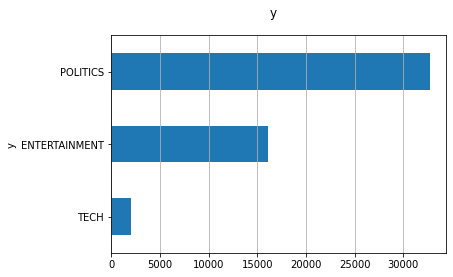

In [8]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)

dtf["y"].reset_index().groupby("y").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
                                                                         
plt.show()

The dataset is imbalanced: the proportion of Tech news is really small compared to the others, this will make for models to recognize Tech news rather tough.
Before explaining and building the models, I am going to give an example of preprocessing by cleaning text, removing stop words, and applying lemmatization. I will write a function and apply it to the whole data set.

In [9]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param 1st_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  ## clean (convert to lowercase and remove puncuations and characters and then strip)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  ## Tokenize (convert from string to list)
  lst_text = text.split()

  ## remove stopwords
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords]

  ## Stemming (remove -ing, -ly, ...)
  if flg_stemm == True:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text] 

  ## Lemmatisation(convert the word into root word)
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]

  ## back to string from list
  text = " ".join(lst_text)
  return text

That function removes a set of words from the corpus if given. I can create a list of generic stop words for the English vocabulary with nltk (we could edit this list by adding or removing words).

In [10]:
# Resource stopwords not found.
# Please use the NLTK Downloader to obtain the resource:

#import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Now apply the function utils_preprocess_text on the whole dataset and store the result in a new column named “text_clean” so that you can choose to work with the raw corpus or the preprocessed text.

In [12]:
dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


I am going to partition the dataset into training set (70%) and test set (30%) in order to evaluate the models performance.

In [13]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [17]:
type(y_test)

numpy.ndarray

## Bag-of-Words

The Bag-of-Words model is simple: it builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. To put it another way, each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”)
As you can imagine, this approach causes a significant dimensionality problem: the more documents you have the larger is the vocabulary, so the feature matrix will be a huge sparse matrix. Therefore, the Bag-of-Words model is usually preceded by an important preprocessing (word cleaning, stop words removal, stemming/lemmatization) aimed to reduce the dimensionality problem.
Terms frequency is not necessarily the best representation for text. In fact, you can find in the corpus common words with the highest frequency but little predictive power over the target variable. To address this problem there is an advanced variant of the Bag-of-Words that, instead of simple counting, uses the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

### Feature Engineering
Feature Engineering, the process to create features by extracting information from the data. I am going to use the Tf-Idf vectorizer with a limit of 10,000 words (so the length of my vocabulary will be 10k), capturing unigrams (i.e. “new” and “york”) and bigrams (i.e. “new york”)
Code for the classic count vectorizer is as well provided:

In [14]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## TF-IDF (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))


Now I will use the vectorizer on the preprocessed corpus of the train set to extract a vocabulary and create the feature matrix

In [15]:
corpus = dtf_train["text_clean"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [16]:
X_train.shape

(35615, 10000)

The feature matrix X_train has a shape of 34,265 (Number of documents in training) x 10,000 (Length of vocabulary) and it’s pretty sparse:

Text(0.5, 1.0, 'Sparse Matrix Sample')

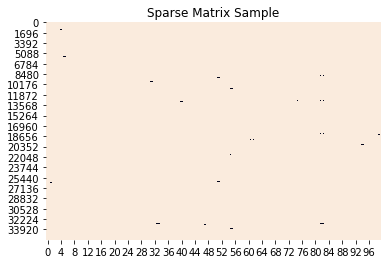

In [17]:
##
sns.heatmap(X_train.todense()[:, np.random.randint(0, X_train.shape[1], 100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In order to know the position of a certain word, we can look it up in the vocabulary

In [18]:
word = "new york"
dic_vocabulary[word]

6001

If the word exists in the vocabulary, this command prints a number N, meaning that the Nth feature of the matrix is that word.

## Dimensionality Reduction
In order to drop some columns and reduce the matrix dimensionality, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:
treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
keep only the features with a certain p-value from the Chi-Square test.

In [20]:
## BUG BUG ERROR ERROR NEEDS TO BE FIXED IN THIS CODE
## DONOT RUN THIS CELL
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
  chi2, p = feature_selection.chi2(X_train, y==cat)
  dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
  dtf_features = dtf_features.sort_values(["y", "score"], ascending=[True, False])
  dtf_features = dtf_features[dtf_features["score"]>p_value_limit]

  X_names = dtf_features["feature"].unique().tolist()

In [20]:
# all lists must be of same length
print(len(X_names), len(y)) # Print all of them out here
#len(np.unique(y))

3086 35615


I reduced the number of features from 10,000 to 3,152 by keeping the most statistically relevant ones. Let’s print some:

In [28]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
         
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# ENTERTAINMENT:
  . selected features: 3086
  . top features: actor,album,award,box,box office,celebrity,clinton,dead,democrat,donald
 
# POLITICS:
  . selected features: 0
  . top features: 
 
# TECH:
  . selected features: 0
  . top features: 
 


We can refit the vectorizer on the corpus by giving this new set of words as input. That will produce a smaller feature matrix and a shorter vocabulary

In [29]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

The new feature matrix X_train has a shape of is 34,265 (Number of documents in training) x 3,152 (Length of the given vocabulary). Let’s see if the matrix is less sparse:

## Train Model
It’s time to train a machine learning model and test it. I recommend using a Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes’ Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability


In [30]:
classifier = naive_bayes.MultinomialNB()

I’m going to train this classifier on the feature matrix and then test it on the transformed test set. To that end, I need to build a scikit-learn pipeline: a sequential application of a list of transformations and a final estimator. Putting the Tf-Idf vectorizer and the Naive Bayes classifier in a pipeline allows us to transform and predict test data in just one step.

In [31]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)


## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

We can now evaluate the performance of the Bag-of-Words model, I will use the following metrics:
  Accuracy: the fraction of predictions the model got right.
  Confusion Matrix: a summary table that breaks down the number of correct and incorrect predictions by each class.
  ROC: a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.
  Precision: the fraction of relevant instances among the retrieved instances.
Recall: the fraction of the total amount of relevant instances that were actually retrieved.

Accuracy :  0.91
AUC :  0.96
Detail : 
Detail : 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


               precision    recall  f1-score   support

ENTERTAINMENT       0.90      0.88      0.89      4808
     POLITICS       0.91      0.97      0.94      9818
         TECH       0.96      0.20      0.33       638

     accuracy                           0.91     15264
    macro avg       0.92      0.68      0.72     15264
 weighted avg       0.91      0.91      0.90     15264



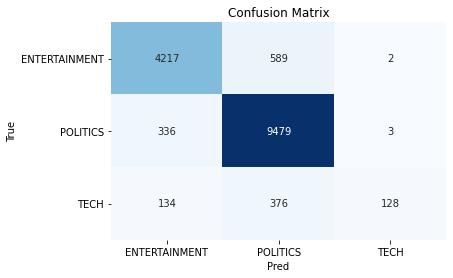

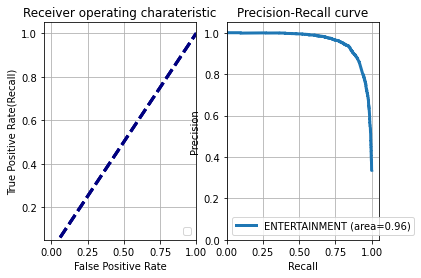

In [34]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")

print("Accuracy : ", round(accuracy,2))
print("AUC : ", round(auc,2))
print("Detail : ")
print("Detail : ")
print(metrics.classification_report(y_test, predicted))

## Plot Confusion Matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,yticklabels=classes, title="Confusion Matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot ROC
for i in range(len(classes)):
  fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:, i])
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05, 1.0], ylim=[0.05, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate(Recall)",
            title="Receiver operating charateristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
  precision, recall, thresholds = metrics.precision_recall_curve(
      y_test_array[:,i], predicted_prob[:,i]) 
  ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i],
                                                                         metrics.auc(recall, precision))
  )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()
  
  

